<a href="https://colab.research.google.com/github/Yassineka99/Analysis_of_Property_Prices_in_Tunisia/blob/main/Analysis_of_Property_Prices_in_Tunisia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pyspark

In [25]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType,StructType, StructField , FloatType
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
import matplotlib.pyplot as plt
from google.colab import files

In [26]:
uploaded = files.upload()

Saving Property Prices in Tunisia.csv to Property Prices in Tunisia (1).csv


In [27]:
# Get the file name
file_name = list(uploaded.keys())[0]
# Load dataset into a Pandas DataFrame
df = pd.read_csv(file_name)

spark = SparkSession.builder.appName("PropertyPricePrediction").getOrCreate()

In [28]:
print(df.dtypes)


category           object
room_count        float64
bathroom_count    float64
size              float64
type               object
price             float64
city               object
region             object
log_price         float64
dtype: object


In [29]:
schema = StructType([
    StructField("category", StringType(), True),
    StructField("room_count", FloatType(), True),
    StructField("bathroom_count", FloatType(), True),
    StructField("size", FloatType(), True),
    StructField("type", StringType(), True),
    StructField("price", FloatType(), True),
    StructField("city", StringType(), True),
    StructField("region", StringType(), True),
    StructField("log_price", FloatType(), True)
])
data = spark.createDataFrame(df, schema=schema)



data.printSchema()
data.show()

root
 |-- category: string (nullable = true)
 |-- room_count: float (nullable = true)
 |-- bathroom_count: float (nullable = true)
 |-- size: float (nullable = true)
 |-- type: string (nullable = true)
 |-- price: float (nullable = true)
 |-- city: string (nullable = true)
 |-- region: string (nullable = true)
 |-- log_price: float (nullable = true)

+--------------------+----------+--------------+------+--------+--------+------+-------------------+---------+
|            category|room_count|bathroom_count|  size|    type|   price|  city|             region|log_price|
+--------------------+----------+--------------+------+--------+--------+------+-------------------+---------+
|  Terrains et Fermes|      -1.0|          -1.0|  -1.0|À Vendre|100000.0|Ariana|             Raoued|      5.0|
|  Terrains et Fermes|      -1.0|          -1.0|  -1.0|À Vendre|316000.0|Ariana|      Autres villes| 5.499687|
|        Appartements|       2.0|           1.0|  80.0| À Louer|   380.0|Ariana|      Autres

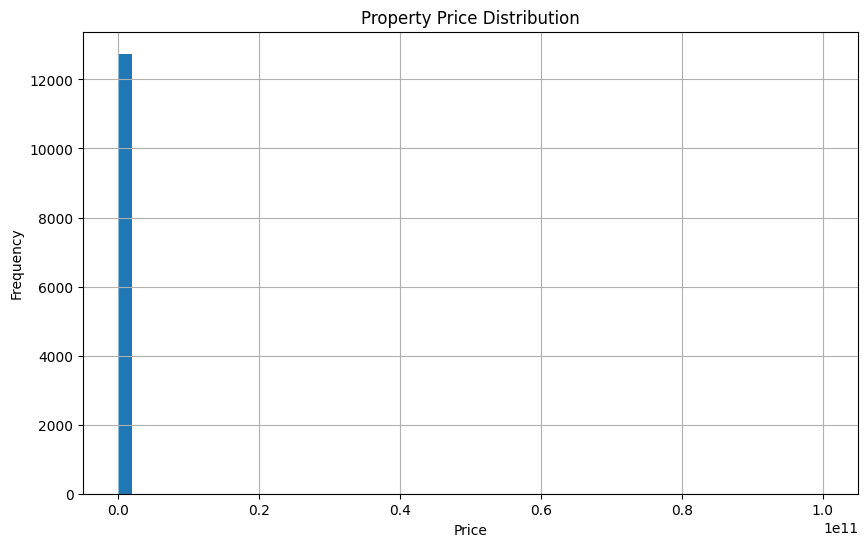

In [30]:
plt.figure(figsize=(10, 6))
df["price"].hist(bins=50)
plt.title("Property Price Distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

In [9]:
indexers = [
    StringIndexer(inputCol="category", outputCol="category_index"),
    StringIndexer(inputCol="type", outputCol="type_index"),
    StringIndexer(inputCol="city", outputCol="city_index"),
    StringIndexer(inputCol="region", outputCol="region_index")
]

for indexer in indexers:
    data = indexer.fit(data).transform(data)


In [10]:
assembler = VectorAssembler(
    inputCols=["city_index","room_count","category_index","region_index","type_index","size","bathroom_count","log_price"],
    outputCol="vector"
)
data = assembler.transform(data)

In [11]:
data.show()

+--------------------+----------+--------------+------+--------+--------+------+-------------------+---------+--------------+----------+----------+------------+--------------------+
|            category|room_count|bathroom_count|  size|    type|   price|  city|             region|log_price|category_index|type_index|city_index|region_index|              vector|
+--------------------+----------+--------------+------+--------+--------+------+-------------------+---------+--------------+----------+----------+------------+--------------------+
|  Terrains et Fermes|      -1.0|          -1.0|  -1.0|À Vendre|100000.0|Ariana|             Raoued|      5.0|           1.0|       0.0|       1.0|         9.0|[1.0,-1.0,1.0,9.0...|
|  Terrains et Fermes|      -1.0|          -1.0|  -1.0|À Vendre|316000.0|Ariana|      Autres villes| 5.499687|           1.0|       0.0|       1.0|         0.0|[1.0,-1.0,1.0,0.0...|
|        Appartements|       2.0|           1.0|  80.0| À Louer|   380.0|Ariana|      Autr

In [12]:
# Select features and label for the model
final_data = data.select("vector", "price")

# Split the data into training and testing sets
train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)

# Train the Linear Regression model
lr = LinearRegression(featuresCol="vector", labelCol="price")
lr_model = lr.fit(train_data)


In [ ]:
# Evaluate the model
test_results = lr_model.evaluate(test_data)
print(f"R2: {test_results.r2}")
print(f"Root Mean Squared Error (RMSE): {test_results.rootMeanSquaredError}")

In [14]:
# Predict on test data
predictions = lr_model.transform(test_data)
predictions.show(5)

+--------------------+-------+--------------------+
|              vector|  price|          prediction|
+--------------------+-------+--------------------+
|[1.0,-1.0,1.0,0.0...|30000.0|-2.34807819173053...|
|[1.0,-1.0,1.0,0.0...|45000.0|-1.834425903990407E8|
|[1.0,-1.0,1.0,0.0...|48000.0|-1.75266771537613...|
|[1.0,-1.0,1.0,0.0...|75000.0|-1.18730107832197...|
|[1.0,-1.0,1.0,0.0...|90000.0|-9.563307181904411E7|
+--------------------+-------+--------------------+
only showing top 5 rows



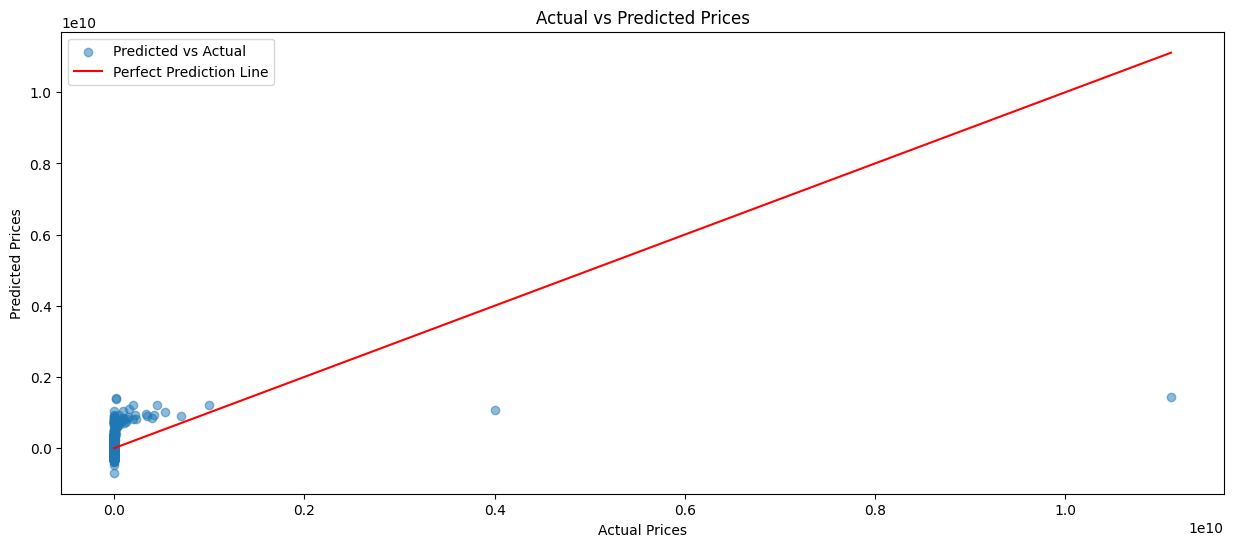

In [15]:
# Visualize predictions vs actual prices
predictions_pd = predictions.select("price", "prediction").toPandas()
plt.figure(figsize=(15, 6))
plt.scatter(predictions_pd["price"], predictions_pd["prediction"], alpha=0.5, label="Predicted vs Actual")
plt.plot(
    [0, max(predictions_pd["price"])],
    [0, max(predictions_pd["price"])],
    color='red',
    linestyle='-',
    label="Perfect Prediction Line"
)
plt.title("Actual vs Predicted Prices")
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.legend()
plt.show()

In [17]:
from pyspark.sql import functions as F
data = data.withColumn("price_transformed", F.pow(10, data["log_price"]))
assembler = VectorAssembler(
    inputCols=["city_index","room_count","category_index","region_index","type_index","size","bathroom_count","price_transformed"],
    outputCol="vector2"
)
data = assembler.transform(data)
data.show()

+--------------------+----------+--------------+------+--------+--------+------+-------------------+---------+--------------+----------+----------+------------+--------------------+------------------+--------------------+
|            category|room_count|bathroom_count|  size|    type|   price|  city|             region|log_price|category_index|type_index|city_index|region_index|              vector| price_transformed|             vector2|
+--------------------+----------+--------------+------+--------+--------+------+-------------------+---------+--------------+----------+----------+------------+--------------------+------------------+--------------------+
|  Terrains et Fermes|      -1.0|          -1.0|  -1.0|À Vendre|100000.0|Ariana|             Raoued|      5.0|           1.0|       0.0|       1.0|         9.0|[1.0,-1.0,1.0,9.0...|          100000.0|[1.0,-1.0,1.0,9.0...|
|  Terrains et Fermes|      -1.0|          -1.0|  -1.0|À Vendre|316000.0|Ariana|      Autres villes| 5.499687|  

In [18]:
# Select features and label for the model
final_data = data.select("vector2", "price")

# Split the data into training and testing sets
train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)

# Train the Linear Regression model
lr = LinearRegression(featuresCol="vector2", labelCol="price")
lr_model = lr.fit(train_data)

In [19]:
# Evaluate the model
test_results = lr_model.evaluate(test_data)
print(f"R2: {test_results.r2}")
print(f"Root Mean Squared Error (RMSE): {test_results.rootMeanSquaredError}")

R2: 0.9999999999995786
Root Mean Squared Error (RMSE): 155.67750589425503


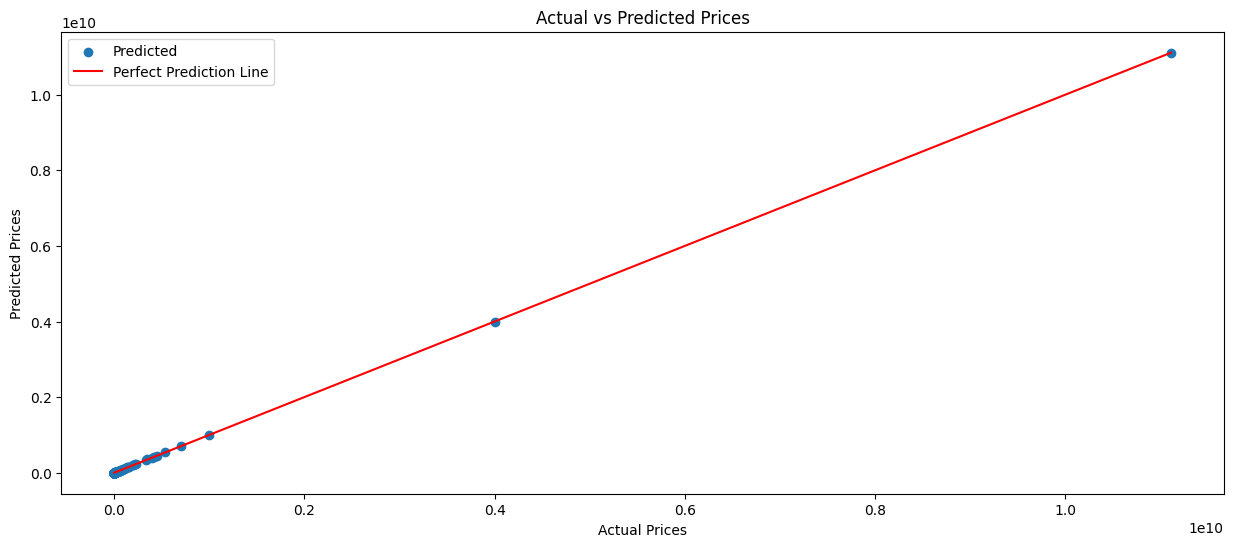

In [23]:
# Visualize predictions vs actual prices
predictions = lr_model.transform(test_data)
predictions_pd = predictions.select("price", "prediction").toPandas()
plt.figure(figsize=(15, 6))
plt.scatter(predictions_pd["price"], predictions_pd["prediction"], alpha=1, label="Predicted")
plt.plot(
    [0, max(predictions_pd["price"])],
    [0, max(predictions_pd["price"])],
    color='red',
    linestyle='-',
    label="Perfect Prediction Line"
)
plt.title("Actual vs Predicted Prices")
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.legend()
plt.show()

In [31]:
predictions.show()

+--------------------+---------+------------------+
|             vector2|    price|        prediction|
+--------------------+---------+------------------+
|[1.0,-1.0,1.0,0.0...|  30000.0|29989.104175859622|
|[1.0,-1.0,1.0,0.0...|  45000.0| 44989.09705707422|
|[1.0,-1.0,1.0,0.0...|  48000.0| 47989.07050808665|
|[1.0,-1.0,1.0,0.0...|  75000.0| 74989.04658142728|
|[1.0,-1.0,1.0,0.0...|  90000.0| 89989.12299855615|
|[1.0,-1.0,1.0,0.0...| 105000.0|104989.05755158159|
|[1.0,-1.0,1.0,0.0...| 135000.0|134989.11184112582|
|[1.0,-1.0,1.0,0.0...| 150000.0|149989.04461246124|
|[1.0,-1.0,1.0,0.0...| 220000.0|219988.95030714624|
|[1.0,-1.0,1.0,0.0...| 220000.0|219988.95030714624|
|[1.0,-1.0,1.0,0.0...| 250000.0| 249989.1281854654|
|[1.0,-1.0,1.0,0.0...| 250000.0| 249989.1281854654|
|[1.0,-1.0,1.0,0.0...| 250000.0| 249989.1281854654|
|[1.0,-1.0,1.0,0.0...| 315000.0|314989.03412034386|
|[1.0,-1.0,1.0,0.0...| 400000.0| 399988.8654917828|
|[1.0,-1.0,1.0,0.0...| 680000.0| 679989.1336091575|
|[1.0,-1.0,1